In [104]:
import bs4 as bs
import os
from multiprocessing import Pool
import pandas as pd
import re
import numpy as np
import seaborn as sns
import pylab as plt
%matplotlib inline

In [13]:
def write_paper(html):
    #ID
    doi = html.find("article-id",{"pub-id-type":"doi"}).text
    #Type
    type_ = html.find("subj-group",{"subj-group-type":"heading"}).text#,{"subj-group-type":"Discipline-v3"})
    #Dates
    published = html.find("pub-date",{"pub-type":"epub"})
    published = "/".join([published.find(_).text for _ in ["year","month","day"]])
    received = html.find("date",{"date-type":"received"})
    received = "/".join([received.find(_).text for _ in ["year","month","day"]])
    accepted = html.find("date",{"date-type":"accepted"})
    accepted = "/".join([accepted.find(_).text for _ in ["year","month","day"]])
    
    
    #Title
    title = html.find("article-title").text.replace("\n"," ").replace("\t"," ").replace("\r"," ")
        
    #categories
    cats = []
    for cat in html.find_all("subj-group", {"subj-group-type":re.compile("Discipline-v*")}):
        cats.append(cat.find("subject").text)
        
    cats = " ::: ".join(list(set(cats)))
    return ["\t".join([doi,type_,published,received,accepted,title,cats])]
    

def write_authors(html):
    doi = html.find("article-id",{"pub-id-type":"doi"}).text
    
    authors = []
    for author in html.find_all("contrib",{"contrib-type":"author"}):
        
        #Author name
        try:
            name = " ::: ".join([_.text for _ in author.find("name")])
        except:
            continue #no author, a research group

        #Author ID (if available)
        orcid = author.find("contrib-id",{"contrib-id-type":"orcid"})
        if orcid is not None:
            orcid = orcid.text
        else:
            orcid = ""

        #Roles
        roles = " ::: ".join([_.text for _ in author.find_all("role")])

        #Addresses
        add = []
        corr = "0"
        for aff in author.find_all("xref"):
            rid = aff.get("rid")
            if "cor" in rid:
                corr = "1"
            else:
                
                try:
                    add.append(html.find("aff",{"id":rid}).find("addr-line").text)
                except:
                    pass #other field
                    
                

        add = " ::: ".join(add)

        authors.append("\t".join([doi,name,orcid,roles,add,corr]))
    
    return authors        
        

def write_editor(html):
    doi = html.find("article-id",{"pub-id-type":"doi"}).text
    
    editors = []
    for author in html.find_all("contrib",{"contrib-type":"editor"}):
        #Author name
        name = " ::: ".join([_.text for _ in author.find("name")])

        #Addresses
        add = []
        for aff in author.find_all("xref"):
            rid = aff.get("rid")
            try:
                add.append(html.find("aff",{"id":rid}).find("addr-line").text)
            except:
                pass #another field

        add = " ::: ".join(add)
        
        editors.append("\t".join([doi,name,add]))
        
    return editors

In [16]:
def process_results(results,f):
    """
    Here fast thing with results (e.g. save to file)
    """
    for line in results:
        f.write(line+"\n")  
            
def create_results(paper):
    """
    Here slow thing with dataframe
    """
    html = bs.BeautifulSoup(open("{}{}".format(path,paper)).read(),"xml")
    if html.find("article").get("article-type") != 'research-article':
        return 0

    try:
        return [write_paper(html),write_editor(html),write_authors(html)]
    except:
        return 1


In [17]:
path = "./data_raw/PLoS_One/"
papers = os.listdir(path)

skipped = 0

with open("./data/papers.tsv","w+") as f_paper, \
     open("./data/editors.tsv","w+") as f_editor, \
     open("./data/authors.tsv","w+") as f_author:
            
    f_paper.write("{}\t{}\t{}\t{}\t{}\t{}\t{}\n".format("doi","type_","published","received","accepted","title","cats"))
    f_author.write("{}\t{}\t{}\t{}\t{}\t{}\n".format("doi","name","orcid","roles","add","corr"))
    f_editor.write("{}\t{}\t{}\n".format("doi","name","add"))


    with Pool() as pool:
        for results in pool.imap_unordered(create_results, papers):
            if isinstance(results,int):
                skipped += results
            else:
                process_results(results[0],f_paper)
                process_results(results[1],f_editor)
                process_results(results[2],f_author)


In [5]:
skipped

53

## Add gender

In [2]:
import pandas as pd
import time
import requests
import json

In [21]:
def get_gender(name):
    last,first,*_ = name.split(" ::: ")
    path = "http://abel.lis.illinois.edu/cgi-bin/ethnea/search.py?Fname={0}&Lname={1}&format=json".format(first, last)
    r = requests.get(path)
    text = r.text.strip().replace('\'', '"')
    x = json.loads(text)
    gender,ethnic = x['Genni'],x["Ethnea"]
    
    #for testing
    #print("{0} {1}".format(first,last), end=" --> ")
    #print("empirical: {0}".format(empirical))
    
    return gender,ethnic

In [6]:
def gender_main(type_):
    df = pd.read_csv("./data/{}.tsv".format(type_),sep="\t")
    gender_map = dict()
    ethnic_map = dict()
    
    unique_names = df["name"].unique()
    for i,name in enumerate(unique_names):
        if isinstance(name,float):
            continue
        if ((i%1000) == 0):
            print("{:2.2f}".format(i/len(unique_names)*100),end = "-")
            
        try:
            gender_map[name],ethnic_map[name] = get_gender(name)
        except:
            print(name)
            
    return df,gender_map,ethnic_map
    

In [ ]:
df,gender_map,ethnic_map = gender_main("editors")

In [22]:
for i in [a for  _ in d.split(" : ") for a in _.split("\n") if ":::" in a]:
    gender_map[i],ethnic_map[i] = get_gender(i)

In [23]:
df["gender"] = df["name"].map(gender_map)
df["ethnicity"] = df["name"].map(ethnic_map)
df.to_csv("./data/editors_gender.tsv",sep="\t",index=None)

In [40]:
papers = pd.read_csv("data/papers.tsv",sep="\t").dropna(subset=["doi","type_","published","received","accepted","title"])
papers.to_csv("data/papers.tsv",sep="\t",index=False)

,doi,type_,published,received,accepted,title,cats,rec_acc,pub_rec
0,10.1371/journal.pone.0089948,Research Article,2014-03-21,2013-10-29,2014-01-23,Brain Entropy Mapping Using fMRI,Physical Sciences ::: Medicine and Health Scie...,86,57
1,10.1371/journal.pone.0062485,Research Article,2013-04-30,2012-10-25,2013-03-21,Replication Study in Chinese Population and Me...,Biology ::: Medicine,147,40
2,10.1371/journal.pone.0012744,Research Article,2010-09-14,2010-04-17,2010-08-11,Phylogeny and Classification of the Trapdoor S...,NaN,116,34
3,10.1371/journal.pone.0038379,Research Article,2012-06-19,2012-02-01,2012-05-04,The Unstable CCTG Repeat Responsible for Myoto...,Biology ::: Medicine,93,46
4,10.1371/journal.pone.0068251,Research Article,2013-06-28,2013-02-07,2013-05-27,Estimating Above-Ground Carbon Biomass in a Ne...,Biology ::: Agriculture ::: Earth Sciences,109,32


## Study gender distributiosn

In [69]:
papers = pd.read_csv("data/papers.tsv",sep="\t",parse_dates=["published","received","accepted"])
papers["acc_rec"] = (papers["accepted"] - papers["received"]).dt.days
papers["pub_acc"] = (papers["published"] - papers["accepted"]).dt.days
papers.head()

,doi,type_,published,received,accepted,title,cats,acc_rec,pub_acc
0,10.1371/journal.pone.0089948,Research Article,2014-03-21,2013-10-29,2014-01-23,Brain Entropy Mapping Using fMRI,Physical Sciences ::: Medicine and Health Scie...,86,57
1,10.1371/journal.pone.0062485,Research Article,2013-04-30,2012-10-25,2013-03-21,Replication Study in Chinese Population and Me...,Biology ::: Medicine,147,40
2,10.1371/journal.pone.0012744,Research Article,2010-09-14,2010-04-17,2010-08-11,Phylogeny and Classification of the Trapdoor S...,NaN,116,34
3,10.1371/journal.pone.0038379,Research Article,2012-06-19,2012-02-01,2012-05-04,The Unstable CCTG Repeat Responsible for Myoto...,Biology ::: Medicine,93,46
4,10.1371/journal.pone.0068251,Research Article,2013-06-28,2013-02-07,2013-05-27,Estimating Above-Ground Carbon Biomass in a Ne...,Biology ::: Agriculture ::: Earth Sciences,109,32


In [94]:
authors = pd.read_csv("data/authors.tsv",sep="\t")
ethnicity = pd.read_csv("data/gender_corr.tsv",sep="\t",header=None,names=["name","gender","eth"])
sample = pd.merge(authors,ethnicity)
sample = sample.loc[sample["gender"] != "-"]
sample.to_csv("data/sample.tsv",sep="\t",index=None)
sample.head()

(1322777, 6) (106678, 3)


,doi,name,orcid,roles,add,corr,gender,eth
29,10.1371/journal.pone.0089948,Childress ::: Anna Rose,NaN,NaN,"Department of Psychiatry, Perelman School of M...",0.0,F,ENGLISH-ITALIAN
30,10.1371/journal.pone.0001506,Childress ::: Anna Rose,NaN,NaN,"Department of Psychiatry, University of Pennsy...",1.0,F,ENGLISH-ITALIAN
31,10.1371/journal.pone.0044556,Childress ::: Anna Rose,NaN,NaN,"Department of Psychiatry, Perelman School of M...",0.0,F,ENGLISH-ITALIAN
32,10.1371/journal.pone.0113256,Childress ::: Anna Rose,NaN,NaN,"Department of Psychiatry, School of Medicine, ...",0.0,F,ENGLISH-ITALIAN
33,10.1371/journal.pone.0104102,Childress ::: Anna Rose,NaN,NaN,Perelman School of Medicine at the University ...,0.0,F,ENGLISH-ITALIAN


In [116]:
editors = pd.read_csv("data/editors_gender.tsv",sep="\t")[["doi","name","gender","ethnicity"]]
editors.columns = ["doi","name_editor","gender_editor","eth_editor"]
editors = editors.loc[editors["gender_editor"]!="-"]
editors.head()

,doi,name_editor,gender_editor,eth_editor
0,10.1371/journal.pone.0089948,Hayasaka ::: Satoru,M,JAPANESE
1,10.1371/journal.pone.0062485,Gorlova ::: Olga Y.,F,SLAV
2,10.1371/journal.pone.0012744,Welch ::: John J.,M,ENGLISH
3,10.1371/journal.pone.0038379,Batzer ::: Mark A.,M,ENGLISH
4,10.1371/journal.pone.0068251,Convertino ::: Matteo,M,ITALIAN


In [117]:
df = pd.merge(sample,papers)
df = pd.merge(editors,df)
df.head()

,doi,name_editor,gender_editor,eth_editor,name,orcid,roles,add,corr,gender,eth,type_,published,received,accepted,title,cats,acc_rec,pub_acc
0,10.1371/journal.pone.0089948,Hayasaka ::: Satoru,M,JAPANESE,Childress ::: Anna Rose,NaN,NaN,"Department of Psychiatry, Perelman School of M...",0.0,F,ENGLISH-ITALIAN,Research Article,2014-03-21,2013-10-29,2014-01-23,Brain Entropy Mapping Using fMRI,Physical Sciences ::: Medicine and Health Scie...,86,57
1,10.1371/journal.pone.0012744,Welch ::: John J.,M,ENGLISH,Brewer ::: Michael S.,NaN,NaN,North Carolina Center for Biodiversity and Dep...,0.0,M,ENGLISH,Research Article,2010-09-14,2010-04-17,2010-08-11,Phylogeny and Classification of the Trapdoor S...,NaN,116,34
2,10.1371/journal.pone.0012744,Welch ::: John J.,M,ENGLISH,Bond ::: Jason E.,NaN,NaN,North Carolina Center for Biodiversity and Dep...,1.0,M,ENGLISH,Research Article,2010-09-14,2010-04-17,2010-08-11,Phylogeny and Classification of the Trapdoor S...,NaN,116,34
3,10.1371/journal.pone.0038379,Batzer ::: Mark A.,M,ENGLISH,Ishida ::: Takafumi,NaN,NaN,"Department of Biological Sciences, Graduate Sc...",0.0,M,JAPANESE,Research Article,2012-06-19,2012-02-01,2012-05-04,The Unstable CCTG Repeat Responsible for Myoto...,Biology ::: Medicine,93,46
4,10.1371/journal.pone.0038379,Batzer ::: Mark A.,M,ENGLISH,Ohno ::: Kinji,NaN,NaN,"Division of Neurogenetics, Center for Neurolog...",0.0,M,JAPANESE,Research Article,2012-06-19,2012-02-01,2012-05-04,The Unstable CCTG Repeat Responsible for Myoto...,Biology ::: Medicine,93,46


In [98]:
df = df.loc[df["acc_rec"]<400]

In [89]:
df.shape

(577, 18)

AFRICAN 137.62573673870335 35.786836935166995
ARAB 131.99975161450573 36.725782414307005
CHINESE 129.61515116811728 35.95705451213926
DUTCH 131.26275624719437 36.671704324405205
ENGLISH 123.28349642453895 37.070780015054574
ENGLISH-FRENCH 121.71345029239767 36.41033138401559
ENGLISH-GERMAN 121.99319727891157 37.3469387755102
FRENCH 123.49758071610803 36.09888273071171
GERMAN 123.79991883116882 35.687702922077925
GERMAN-ENGLISH 123.61870503597122 35.86810551558753
GREEK 120.77891654465593 36.20571010248902
HISPANIC 128.73709804875082 34.85800255303629
INDIAN 124.49029048306853 36.52961001444391
ISRAELI 123.22613636363636 36.68295454545454
ITALIAN 122.16744816088361 35.55600708554757
JAPANESE 122.92206947043033 33.759781989750266
KOREAN 132.11188066062866 32.42194992008524
NORDIC 126.59475756829929 35.23590942653212
SLAV 124.58200562324274 34.206747891283975


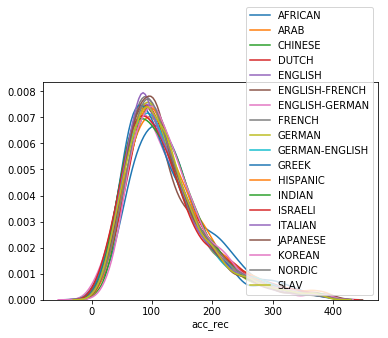

In [110]:
for gender,data in df.groupby(["eth"]):
    if len(data) < 1000:
        continue
    print(gender,np.mean(data["acc_rec"]),np.mean(data["pub_acc"]))
    #sns.distplot(data["pub_acc"],hist=False,label=gender)
    sns.distplot(data["acc_rec"],hist=False,label=gender)
    
plt.legend()

In [115]:
from scipy.stats import mannwhitneyu
mannwhitneyu(df.loc[df["gender"]=="F","acc_rec"].values,df.loc[df["gender"]=="M","acc_rec"].values)

MannwhitneyuResult(statistic=3834031690.5, pvalue=6.6602668731348845e-82)

F 58030 135.92210925383424 35.74613131139066
M 139764 130.14461520849432 35.94342606107438


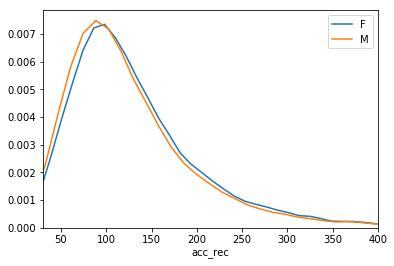

In [154]:
for gender,data in df.groupby(["gender"]):
    print(gender,len(data),np.mean(data["acc_rec"]),np.mean(data["pub_acc"]))
    #sns.distplot(data["pub_acc"],hist=False,label=gender)
    sns.distplot(data["acc_rec"],hist=False,label=gender)
plt.xlim([30,400])
plt.legend()

In [144]:
all_data = []
for ed,data in df.groupby("name_editor"):
    if len(data)>100:
        data_editor = [ed]
        for gender,data2 in data.groupby("gender"):
            data_editor.append(np.mean(data2["acc_rec"]))
            #print(gender,len(data2),np.mean(data2["acc_rec"]),np.mean(data2["pub_acc"]))
        all_data.append(data_editor)

In [145]:
editor_results = pd.DataFrame(all_data)
editor_results['"bias"'] = editor_results[2]-editor_results[1]
editor_results = pd.merge(editor_results,editors.drop_duplicates(subset=["name_editor"]),left_on=0,right_on="name_editor")
editor_results["gender_editor"] = editor_results["gender_editor"].replace({"F":1,"M":0})
editor_results.sort_values(by='"bias"')

,0,1,2,"""bias""",doi,name_editor,gender_editor,eth_editor
237,Puebla ::: Iratxe,457.297297,398.108108,-59.189189,10.1371/journal.pone.0193219,Puebla ::: Iratxe,1,HISPANIC
87,Deli ::: Maria A.,167.925926,123.938053,-43.987873,10.1371/journal.pone.0050360,Deli ::: Maria A.,1,ITALIAN-HUNGARIAN
81,Câmara ::: Niels Olsen Saraiva,187.567568,146.934066,-40.633502,10.1371/journal.pone.0013930,Câmara ::: Niels Olsen Saraiva,0,HISPANIC
173,Lebedeva ::: Irina V.,218.965517,180.370370,-38.595147,10.1371/journal.pone.0081320,Lebedeva ::: Irina V.,1,SLAV
238,Pöhlmann ::: Stefan,157.062500,118.518868,-38.543632,10.1371/journal.pone.0103294,Pöhlmann ::: Stefan,0,GERMAN
187,Matsunami ::: Hiroaki,181.171429,144.234234,-36.937194,10.1371/journal.pone.0048072,Matsunami ::: Hiroaki,0,JAPANESE
3,Agoulnik ::: Irina,168.320000,131.833333,-36.486667,10.1371/journal.pone.0025975,Agoulnik ::: Irina,1,ENGLISH-GERMAN
172,Lazzeri ::: Chiara,156.473684,120.431034,-36.042650,10.1371/journal.pone.0125284,Lazzeri ::: Chiara,1,ITALIAN
7,Ahuja ::: Sunil K.,191.444444,155.873684,-35.570760,10.1371/journal.pone.0040676,Ahuja ::: Sunil K.,0,INDIAN
203,Moura ::: Ivan Cruz,147.050000,111.593750,-35.456250,10.1371/journal.pone.0025704,Moura ::: Ivan Cruz,0,HISPANIC-FRENCH


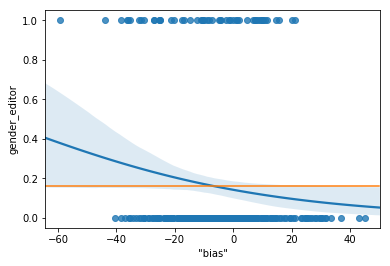

In [150]:
sns.regplot(y='gender_editor',x='"bias"',data=editor_results,logistic=True)
plt.plot([-65,50],[editor_results["gender_editor"].mean(),editor_results["gender_editor"].mean()])